## This notebook is used to preprocess data and transform into an appropriate format for an LSTM

In [4]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
import pandas
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Create a mapping to transform the dataset into columns per sensor

In [60]:
replacement_mapping_dict = {
            "M01" : 0,
            "M02" : 1,
            "M03" : 2,
            "M04" : 3,
            "M05" : 4,
            "M06" : 5,
            "M07" : 6,
            "M08" : 7,
            "M09" : 8,
            "M10" : 9,
            "M11" : 10,
            "M12" : 11,
            "M13" : 12,
            "M14" : 13,
            "M15" : 14,
            "M16" : 15,
            "M17" : 16,
            "M18" : 17,
            "M19" : 18,
            "M20" : 19,
            "M21" : 20,
            "M22" : 21,
            "M23" : 22,
            "M24" : 23,
            "M25" : 24,
            "M26" : 25,
            "I01" : 26,
            "I02" : 27,
            "I03" : 28,
            "I04" : 29,
            "I05" : 30,
            "I06" : 31,
            "I07" : 32,
            "I08" : 33,
            "D01" : 34,
            "AD1-A" : 35,
            "AD1-B" : 36,
            "AD1-C" : 37,
        }

Load the dataset.

In [6]:
dataset = read_csv('datasets/adlnormal/data.csv')
# for now exclude asterisk and EO1
dataset = dataset[dataset["SensorId"] != "E01"]
dataset = dataset[dataset["SensorId"] != "asterisk"]

# replace ON/OFF for light sensors, ABSENT/PRESENT for bowls/food and OPEN/CLOSE for door sensors
dataset["SensorValue"] = dataset["SensorValue"].replace({"ON" : 1.0, "OFF" : 0.0})
dataset["SensorValue"] = dataset["SensorValue"].replace({"ABSENT" : 1.0, "PRESENT" : 0.0})
dataset["SensorValue"] = dataset["SensorValue"].replace({"OPEN" : 1.0, "CLOSE" : 0.0})
# transform sensorids from text into numbers to make life easier
dataset["SensorId"].replace(replacement_mapping_dict, inplace=True)
# drop the event labelling as we aren't predicting activities
dataset.drop('Event', axis=1, inplace=True)

Now, create a transformed data set where the columns represent the various sensor values.
Furthermore, collate the data into 10 second segments to reduce sparcity. 
To avoid empty fields, oscillations of on/off values will be simply reported as 1 - representing activation

In [30]:
data = []
current_date = dataset.iloc[0]["Date"]
first_row_time = dataset.iloc[0]["Time"].split(".")
first_row_time = first_row_time[:1]
current_time = ((datetime.strptime(first_row_time[0], "%H:%M:%S").second // 10 ) + 1 ) * 10 
if (current_time > 50):
    current_time = 60
sensor_vals = [0.0] * 38
first_time = datetime.strptime(first_row_time[0], "%H:%M:%S")
date_and_time = []
date_and_time.append(current_date)
date_and_time.append(str(first_time.hour) + ":" + str(first_time.minute) + "." + str(current_time))
for i, row in dataset.iterrows():
    date = row["Date"]
    time = row["Time"].split(".")
    time = time[:1]
    time = datetime.strptime(time[0], "%H:%M:%S")
    if ((current_time == 60 and time.second < current_time ) or time.second >= current_time):
        date_and_time.extend(sensor_vals)
        data.append(date_and_time)
        date_and_time = []
        current_date = date
        if (current_time == 60):
            current_time = 10
        else:
            current_time += 10
        sensor_vals = [0.0] * 38
        if (sensor_vals[int(row["SensorId"])] != 1.0):
            sensor_vals[int(row["SensorId"])] = row["SensorValue"]
        date_and_time.append(row["Date"])
        new_time = str(time.hour) + ":" + str(time.minute) + "." + str(current_time)
        date_and_time.append(new_time)
    if (sensor_vals[int(row["SensorId"])] != 1.0):
        sensor_vals[int(row["SensorId"])] = row["SensorValue"]
columns = [i for i in range (0,38)]
final_columns = ["Date", "Time"]
final_columns.extend(columns)
new_data = pandas.DataFrame.from_records(data, columns=final_columns)      

38
            Date      Time    0    1    2    3    4    5    6    7  ...   28  \
0     2008-02-27  12:43.30  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  ...  0.0   
1     2008-02-27  12:43.40  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2     2008-02-27  12:43.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3     2008-02-27  12:44.60  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4     2008-02-27  12:45.10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...          ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1910  2008-05-21  16:46.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1911  2008-05-21  16:46.60  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1912  2008-05-21  16:46.10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1913  2008-05-21  16:46.20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1914  2008-05-21  16:46.30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

       29   30   31   32   33   34  

Plot the data to identify useless fields

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1910    0.0
1911    0.0
1912    0.0
1913    0.0
1914    0.0
Name: 0, Length: 1915, dtype: float64


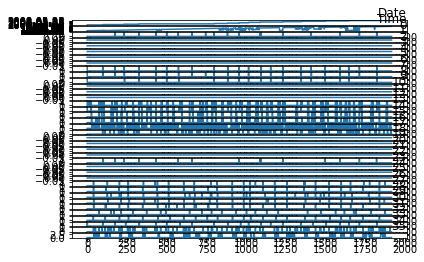

Irrelevant columns are:  [1, 2, 3, 4, 5, 9, 10, 11, 18, 19, 20, 21, 23, 24, 25]


In [35]:
values = new_data.values
groups = []
empty_columns = []
for i in range (0,38):
    groups.append(i)
    if ((new_data[i] == new_data[i][0]).all()):
        empty_columns.append(i)
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(new_data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()
print("Irrelevant columns are: ", empty_columns)


Remove empty columns from the data and plot resulting traces

In [63]:
# new_data.drop(empty_columns, axis=1, inplace=True)
reversed_mapping = {y: x for x, y in replacement_mapping_dict.items()}
print(reversed_mapping)
for column in empty_columns:
    reversed_mapping.pop(column)
legend = []
for columnn in new_data.columns:
    if (columnn!="Date" and columnn!="Time"):
        legend.append(reversed_mapping[columnn])
new_data.plot(subplots=True, figsize=(20,20))
pyplot.legend(legend)
pyplot.tight_layout()
pyplot.savefig("plots/CleanedData.png", format="png", dpi=1200)

{0: 'M01', 1: 'M02', 2: 'M03', 3: 'M04', 4: 'M05', 5: 'M06', 6: 'M07', 7: 'M08', 8: 'M09', 9: 'M10', 10: 'M11', 11: 'M12', 12: 'M13', 13: 'M14', 14: 'M15', 15: 'M16', 16: 'M17', 17: 'M18', 18: 'M19', 19: 'M20', 20: 'M21', 21: 'M22', 22: 'M23', 23: 'M24', 24: 'M25', 25: 'M26', 26: 'I01', 27: 'I02', 28: 'I03', 29: 'I04', 30: 'I05', 31: 'I06', 32: 'I07', 33: 'I08', 34: 'D01', 35: 'AD1-A', 36: 'AD1-B', 37: 'AD1-C'}
Index(['Date', 'Time',      0,      6,      7,      8,     12,     13,     14,
           15,     16,     17,     22,     26,     27,     28,     29,     30,
           31,     32,     33,     34,     35,     36,     37],
      dtype='object')
['M01', 'M07', 'M08', 'M09', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M23', 'I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'D01', 'AD1-A', 'AD1-B', 'AD1-C']
